# Genetic algorithm

In this exercise we will use genetic algorithms locate global optima in two different optimzation problems. First we will learn about the genetic algorithm implemented in ASE ([ase.ga]()) by locating the best perovskites for water splitting. Next we will tackle the combinatorially harder problem of the chemical ordering in a bimetallic nanoparticle.

## About genetic algorithms

A Genetic algorithm (GA) takes a Darwinistic approach to optimization by maintaining a *population* of solution *candidates* to a problem (e.g. what is the best chemical ordering of a multi-component system).
- The population is evolved to obtain better solutions by mating and mutating selected candidates and putting the fittest *offspring* in the population.
- The *fitness* of a candidate is a function which, for example, measures the stability or performance of a candidate.
- Natural selection is used to keep a constant population size by removing the least fit candidates.
- Mating or *crossover* combine candidates to create offspring with parts from more candidates present, when favorable traits are combined and passed on the population is evolved. However, only performing crossover operations risks stagnating the evolution due to a lack of diversity -- performing crossover on very similar candidates is unlikely to create progress when performed repeatedly.
- *Mutation* induces diversity in the population and thus prevents premature convergence.

The figure below gives a simplified outline of the algorithm.

![ga-outline](images/ga-outline.png)

GAs are generally applicable to areas where traditional optimization by derivative methods are unsuited and a brute force approach is computationally infeasible.

Furthermore, the output of a GA run will be a selection of optimized candidates, which often will be preferred over only getting the best candidate, especially taking into account the potential inaccuracy of the employed methods. Thus a GA finds many applications within atomic simulations, and will often be one of the best methods for searching large phase spaces.

## Genetic algorithm search for perovskites for water splitting
In the first part we will use a GA to predict the best perovskite for water splitting.

### Background

[Castelli et al](http://xlink.rsc.org/?DOI=c2ee22341d) performed a density functional theory (DFT) screening of $\sim$19000 perovskite materials. Only a small number of the calculated candidate materials ($\sim$20) were found to be sufficiently interesting for photocatalytic water splitting to warrant further experimental investigation. A genetic algorithm could reduce the number of calculations required to locate the interesting candidates. We will try to make 19000 into ?

![split-water](images/split-water.png)

The data is publicly [available](https://cmr.fysik.dtu.dk/cubic_perovskites/cubic_perovskites.html#cubic-perovskites), so we can test how few candidates we can get away with calculating for discovering the best candidates. This assignment is similar to that performed by [Jain et al.](http://link.springer.com/10.1007/s10853-013-7448-9). Note we will use the database to look up the results of the calculations, we do not do any DFT calculations in this exercise. It is only a matter of trying to run and optimize the GA.

### Introduction to the database

We will try and browse through the data a bit to get a feel for what is inside the database. It contains some calculated properties of cubic perovskites, we will use it as a reference when we try to identify the best perovskite for water splitting. Along with the perovskite compounds, the database also contains reference calculations of the elements in their standard states. We start by connecting to the database (more info on the `ase db` module can be found [here]( https://wiki.fysik.dtu.dk/ase/ase/db/db.html#module-ase.db)), and inspecting a single row:


In [13]:
from ase.db import connect
db = connect('/work3/projects/week11/stly/cubic_perovskites.db')
row = next(db.select())
#vars(row)


Each row of the database has some key-value pairs, which are stored explicitly, as well as some basic information which is always stored, recording how the data was calculated. Below are some values that we will have use for in this exercise.

- heat_of_formation_all
- gllbsc_dir_gap
- gllbsc_ind_gap
- CB_ind, CB_dir
- VB_ind, VB_dir


Each row also has a `toatoms()` method, which lets us extract an ase atoms object from the row.

In [14]:
from ase.visualize import view
view(row.toatoms())

When doing any kind of data analysis, the first step is always to become familiar with the data in question, on a basic level. The `select()` method of the database applies a query to the database and returns an iterator of all the rows matching that query. To select all rows with a user of `einstein`, we would type `db.select(user='einstein')`. To select all rows with a gllbsc direct gap greater than 0.5 eV, we would type `db.select('gllbsc_dir_gap>0.5')`.
Counting the number of hits can be be done using `db.count(key=value)` for some key-value pair.

How many rows are there in the database? 


In [15]:
db.count()

19369

The structures in the database were generated from the general formula ABX, and then varying A, B and X. X represents the anions.
The A, B and X is encoded in values of the keys `A_ion`, `B_ion` and `anion` respectively, i.e. `row.A_ion -> 'Ti'`.


In [16]:
row.A_ion


'Ti'

Taking into account modern day computer power the number of possible candidates does not refrain us from doing a full screening of all combinations. If the number was one or two orders of magnitude higher (easily imagineably by adding more anions or a different class of A/B ions i.e. organic molecules) a full screening would not be feasible. The GA is a good method to use for an optimization problem with a large phase space.

### Start the GA

We will start by putting the reference database into local memory. This makes lookup of values of each candidate much faster. Then we will set up another database that will hold the candidates generated by the GA. We also make two lists called `AB_ions` and `anions` respectively that holds the possibilities for `A`, `B` and `X`. It will be needed to run the GA.

**Note** the cell below takes a little while to execute.

In [17]:
from ga_help import get_raw_score
from operator import itemgetter

# The reference database are put in local memory for faster lookup
ref_dict = {}
all_list = []
A_ions, B_ions, anions = set(), set(), set()
for row in db.select('anion'):
    # Use a key: A-B-X to look up each row
    s = '-'.join([row.A_ion, row.B_ion, row.anion])
    A_ions.add(row.A_ion)
    B_ions.add(row.B_ion)
    anions.add(row.anion)
    ref_dict[s] = row
    all_list.append((s, get_raw_score(row, method='product')))

AB_ions = sorted(list(A_ions))
anions = sorted(list(anions))

combinations = len(AB_ions) ** 2 * len(anions)
print(combinations)
print('built ref dictionary')

# sort the list by the raw score
all_list.sort(key=itemgetter(1), reverse=True)
with open('top_list.txt', 'w') as fd:
    for st, rs in all_list:
        print(st, rs, file=fd)


18928
built ref dictionary


Check which A, B and an-ions are available in the phase space.

In [18]:
print('AB ions')
print(AB_ions)
print('Anions')
print(anions)

AB ions
['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca', 'Cd', 'Co', 'Cr', 'Cs', 'Cu', 'Fe', 'Ga', 'Ge', 'Hf', 'Hg', 'In', 'Ir', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Ni', 'Os', 'Pb', 'Pd', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'Sb', 'Sc', 'Si', 'Sn', 'Sr', 'Ta', 'Te', 'Ti', 'Tl', 'V', 'W', 'Y', 'Zn', 'Zr']
Anions
['N3', 'O2F', 'O2N', 'O2S', 'O3', 'OFN', 'ON2']


The variables below are needed to initialize the GA

In [22]:
# File name
from ga_help import get_db_file_name
ga_db_file = get_db_file_name('perovskite')

# Define the population size
pop_size = 50

# Phase space are defined in AB_ions and anions


Here we initialize the database file that holds information about the GA run.

In [29]:
from ase.ga.data import PrepareDB

# Initialize the GA database
prep_ga_db = PrepareDB(ga_db_file,
                       population_size=pop_size,
                       anions=anions, AB_ions=AB_ions)


Now we create the initial population by creating random candidates.

In [30]:
import random

# Construct a random starting population
print('Generating random population of size {0}'.format(pop_size))
start_set = set()
for _ in range(pop_size):
    # Choose two random from AB_ions and one random from anions
    cand = random.sample(AB_ions, 2) + random.sample(anions, 1)
    s = '-'.join(cand)
    # We don't want duplicates in the starting population
    if s in start_set:
        continue
    start_set.add(s)
    # A candidate is added to the database, it is not evaluated (unrelaxed)
    prep_ga_db.add_unrelaxed_candidate(ref_dict[s].toatoms(),
                                       atoms_string=s)
print('Done.')


Generating random population of size 50
Done.


Now the initialization of the database file is finished. You can move on to [Run the GA](#Run-the-GA)

Run the cell below if *and only if* you need to restart the algorithm. It will delete all the progress in the database file.

In [25]:
import os
if os.path.isfile(ga_db_file):
    os.remove(ga_db_file)

### Run the GA

First we need to use a different class for the database.

In [31]:
from ase.ga.data import DataConnection

ga_db = DataConnection(ga_db_file)


Then we will evaluate the starting population. Each candidate is evaluated based on stability (heat of formation), band gap and maximum of valence and minimum of conduction band, they should be positioned at the O$_2$/H$_2$O and H$^+$/H$_2$ potentials respectively. The evaluation of each candidate ends with an assigment of a raw score. The raw score help to determine how fit each candidate is when comparing to the rest of the population. For more information see the function `get_raw_score` in the file ga_help.py

In [32]:
from ga_help import evaluate, get_evaluated_set

# Evaluate the starting population
candidates_to_be_added = []
for a in ga_db.get_all_unrelaxed_candidates():
    evaluate(a, ref_dict)
    candidates_to_be_added.append(a)
ga_db.add_more_relaxed_candidates(candidates_to_be_added)

# Keep track of the candidates that has been evaluated
already_evaluated = get_evaluated_set(ga_db_file)


The algorithm works by maintaining a population of candidates, that is evolved towards the optimal candidates as the algorithm run progresses. Below we initialize the population class.

In [33]:
from ase.ga.standard_comparators import StringComparator
from ase.ga.population import Population

# Define how to compare two different candidates
comp = StringComparator('atoms_string')

# The population is kept in the Population instance
pop = Population(data_connection=ga_db,
                 population_size=pop_size,
                 comparator=comp)


![perovskite](images/perovskite.png)

Each candidate is represented by a list of elements `[A, B, X]`. The algorithm will evolve the population not unlike natural evolution by combining and mutating the best candidates in the population to create new candidates better adjusted to fit the environment.

Evolution takes place through operators, that are defined as individual classes:
- `OnePointListCrossover`
- `RandomListMutation`
- `NeighborhoodListMutation`
- `ListPermutation`
- `RandomListCreation`

Try and see how each operator works. See below for examples

In [34]:
from list_operators import RandomListMutation
from ga_help import get_atoms_string

# Two candidates are selected from the population as parents
a1, a2 = pop.get_two_candidates(with_history=False)

print(get_atoms_string(a1))

# Initialize an operator
random_operator = RandomListMutation([AB_ions, anions])

# Use the get_new_individual method to get a new candidate
# Two parents are accepted even though only one is returned
offspring, desc = random_operator.get_new_individual([a1, a2])
print(desc)
print(get_atoms_string(offspring))


La-In-O2S
RandomListMutation: Parent 85
La-Ir-O2S


In [35]:
from list_operators import OnePointListCrossover

# Get two candidates from the population
a1, a2 = pop.get_two_candidates(with_history=False)

print(get_atoms_string(a1), get_atoms_string(a2))

# Initialize an operator
crossover_operator = OnePointListCrossover()

# The crossover takes two candidates as input and combine to produce offspring
offspring, desc = crossover_operator.get_new_individual([a1, a2])
print(desc)
print(get_atoms_string(offspring))


Mn-Bi-O2F Zn-Ga-O2N
OnePointListCrossover: Parents 67 66
Mn-Bi-O2N


Now we put all the available operators together with probabilities of how often they are selected to produce new candidates.

In [36]:
from ase.ga.offspring_creator import OperationSelector
from list_operators import OnePointListCrossover, RandomListMutation,\
    NeighborhoodListMutation, ListPermutation, RandomListCreation

# Specify the procreation operators for the algorithm
# Try and play with the mutation operators that move to nearby
# places in the periodic table
oclist = ([1, 3, 1, 1, 1], [RandomListMutation([AB_ions, anions]),
                            OnePointListCrossover(),
                            NeighborhoodListMutation([AB_ions, anions]),
                            RandomListCreation([AB_ions, anions], [2, 1]),
                            ListPermutation([AB_ions, anions])])
operation_selector = OperationSelector(*oclist)


Now we write the loop that in essence is the algorithm. Try and run the cell below a couple of times and see that fitter candidates are produced as the population evolves. Then go to the [Analysis](#analysis) section to check how the GA is performing and then come back here and run it some more.

**Note:** The algorithm takes a little bit of time to run so be patient, you can follow the progress in the output cell below.

In [37]:
import numpy as np
from ga_help import set_syms, get_atoms_string

print('Number of evaluated candidates in database: {0}'.format(len(already_evaluated)))
worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
# Get the largest gaid in db
max_id = ga_db.get_largest_in_db('gaid')

# This many candidates will be tested in this loop
num_cands = 1000

# Run the algorithm
add_later = []
found = set()
for i in range(1, num_cands + 1):
    offspring = None
    while offspring is None or s in already_evaluated:
        # Select parents
        a1, a2 = pop.get_two_candidates(with_history=False)
        
        # Select procreation operator
        op = operation_selector.get_operator()
        
        # Do the operation
        offspring = op.get_new_individual([a1, a2])
        
        # Get the candidate as a string to check if it has already
        # been evaluated
        s = get_atoms_string(offspring)

    # Technical details not important
    a3, desc = offspring
    set_syms(a3, ref_dict[s])
    already_evaluated.add(s)
    # We don't save the unrelaxed candidates in this case, due to speed
    # So we have to set an artificial confid
    # db.add_unrelaxed_candidate(a3, description=desc)
    a3.info['confid'] = i + max_id

    # Invoke the evaluation
    evaluate(a3, ref_dict)
    
    # If the evaluated candidate will enter the population it will be saved
    # now, else it is written after the loop terminates
    if a3.info['key_value_pairs']['raw_score'] > worst_raw_score_in_pop:
        ga_db.add_relaxed_step(a3)

        pop.update([a3])
        worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
    else:
        add_later.append(a3)

    # Print the progress of the algorithm for every 50 evaluated candidates
    if i % 50 == 0:
        best = pop.pop[0].info['key_value_pairs']
        worst = pop.pop[-1].info['key_value_pairs']
        print('After {0} evaluations'.format(i))
        print('Best candidate in population:', best['atoms_string'],
              best['raw_score'])
        print('Worst candidate in population:', worst['atoms_string'],
              worst['raw_score'])
        print(50 * '-')
    
print('Writing rest of candidates to database (#{0})'.format(len(add_later)))
ga_db.add_more_relaxed_candidates(add_later)


Number of evaluated candidates in database: 50
After 50 evaluations
Best candidate in population: La-La-O3 142.35406455252195
Worst candidate in population: Pb-Sn-ON2 30.835118698173353
--------------------------------------------------
After 100 evaluations
Best candidate in population: La-La-O3 142.35406455252195
Worst candidate in population: Al-Ti-O2F 45.229303908449765
--------------------------------------------------
After 150 evaluations
Best candidate in population: Ba-Sn-O3 200.0
Worst candidate in population: Mn-V-O2F 58.07132980670045
--------------------------------------------------
After 200 evaluations
Best candidate in population: Ba-Sn-O3 200.0
Worst candidate in population: Ga-Ta-O2N 70.19621866649736
--------------------------------------------------
After 250 evaluations
Best candidate in population: Ba-Sn-O3 200.0
Worst candidate in population: Na-Ti-O3 77.78420465943438
--------------------------------------------------
After 300 evaluations
Best candidate in pop

## Analysis

Since all the candidates have previously been calculated we can evaluate the effectiveness of the algorithm. How quickly it discovers the top candidates compared to a random search.

![top-candidates](images/candidates.png)

Let's see the top candidates with our fitness/raw score

In [38]:
# Print out the top 20 candidates and their raw score
!head -20 top_list.txt

Ca-Nb-O2N 200.0
Ba-Ta-O2N 200.0
Sr-Ta-O2N 200.0
La-Ti-O2N 200.0
Ca-Ta-O2N 200.0
Sr-Nb-O2N 200.0
La-Ta-ON2 200.0
Ag-Ti-O2F 200.0
Sr-Sn-O3 200.0
Ba-Sn-O3 200.0
Sn-Ti-O3 200.0
Na-V-O3 199.53135739731692
Ga-Ta-O3 198.08459850688277
La-Nb-ON2 195.2477506800463
Y-Ta-ON2 192.15788783046463
Ba-Ga-O2F 192.15788783046463
Ba-Nb-O2N 190.9875718040057
Ca-Sn-O3 188.35290671684973
Sr-Ge-O3 188.35290671684973
Ca-Ge-O3 188.35290671684973


Now we can see how many of the top 20 is found by the current algorithm.

In [39]:
# Get the top list from the text file top_list.txt
f = open('top_list.txt')
top_list = []
for l in f:
    top_list.append(l.split(' ')[0])
f.close()

# Only consider the top 20
top_number = 20
top_list = top_list[:top_number]
    
db_ga = connect(ga_db_file)
found = set()
i = 0
for row in db_ga.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        print(f'# found candidates in top {top_number}: {lf}. {s} evaluated as number: {i}')


# found candidates in top 20: 1. Ba-Sn-O3 evaluated as number: 139
# found candidates in top 20: 2. Ca-Sn-O3 evaluated as number: 178
# found candidates in top 20: 3. Sr-Sn-O3 evaluated as number: 199
# found candidates in top 20: 4. Sn-Ti-O3 evaluated as number: 443
# found candidates in top 20: 5. Ga-Ta-O3 evaluated as number: 448
# found candidates in top 20: 6. Sr-Ge-O3 evaluated as number: 453
# found candidates in top 20: 7. Ca-Ge-O3 evaluated as number: 518


Let us compare the performance with a random search. The cell below defines a function that returns the average number of draws it takes to find x number of top candidates [ref](https://math.stackexchange.com/questions/206798/pulling-cards-from-a-deck-without-replacement-to-reach-a-goal-average-draws-nee).

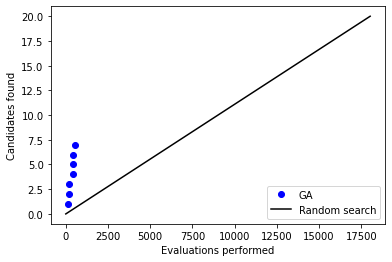

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from plot_help import remove_duplicate_labels

search_space = db.count('anion')
def random_search(number_of_candidates):
    return (number_of_candidates * (search_space + 1)) / (top_number + 1)


# Create the figure object
fig, ax = plt.subplots()

# Plot the number of found candidates by GA as a function of evaluated candidates
found = set()
i = 0
for row in db_ga.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        ax.plot(i, lf, 'bo', label='GA')
        
# Plot the random search
y = np.array(range(top_number + 1))
ax.plot(random_search(y), y, 'k-', label='Random search')


# Put labels on axes
ax.set_xlabel('Evaluations performed')
ax.set_ylabel('Candidates found')

remove_duplicate_labels(ax)


Now let us compare the algorithm performance with using your chemical intuition before doing any calculations. There are three chemical rules we can enforce on the perovskites.

1. Even - odd number of electrons. The total number of electrons should be even. Compounds with odd number of electrons have a partially occupied eigenstate and are therefore metallic with zero band gap.
2. Valence balance. The sum of oxidation states of a realistic ionic compound should be able to be 0.
3. The Goldschmidt tolerance factor. This factor: $\frac{r_A + r_X}{\sqrt{2}(r_B + r_X)}$, where $r_i$ is the ionic radii of the elements, is equal to 1 in an ideal perovskite, meaning that compounds with a tolerance factor far from one are not going to be stable as perovskites. The candidates fulfilling the first two criteria are ranked with respect to the deviation from the optimal Goldschmidt tolerance factor and are evaluated in turn starting with the tolerance closest to one.

The function `get_chemical_intuition_found_list` in the cell below goes through sorted list and returns how many evaluations would be needed to find the candidates in the top list using the rules stated above.

In [46]:
from chemical_intuition import get_chemical_intuition_found_list

# Plot the chemical intuition search
found_with_chemical_intuition = get_chemical_intuition_found_list(top_list)
y_chemical = np.array(range(len(found_with_chemical_intuition)))
ax.plot(found_with_chemical_intuition, y_chemical, 'r-', label='Chemical')
remove_duplicate_labels(ax)
fig

ModuleNotFoundError: No module named 'mendeleev'

Are the GA able to beat chemical intuition?

# GA for nanoalloys

GA is now commonly used as an efficient global optimization approach for bimetallic nanoparticles. The GA search starts by randomly generating a set of atomic configurations of bimetallic nanoparticles, which is defined as the population. Throughout the whole GA search, the size of the population always remains constant. Next, the candidates of the population perform genetic operations including crossover, mutation and selection, to obtain offsprings which constitutes evolving a generation. Crossover operators acts by juxtaposing two different motifs from each participating parent and thereby creating two offsprings with inherited properties. Mutation operators introduce a random small structural change to a chosen parent so that favorable genetic structures can be discovered. All the individual candidates are ranked according to the mixing energy, where lower mixing energies are assigned with higher fitness. By selecting suitable operators and optimal hyperparameters, the GA evolves towards an optimal population in which the structures with lower fitness are eliminated and all remaining structures are low in mixing energy, i.e., thermodynamically stable. The figures below showcase two types of GA run, one with a fixed composition and the other with all possible compositions.

In the second part we will run composition-fixed GA to search for the most stable 1.5 nm diameter icosahedral Ni$_{0.8}$Pt$_{0.2}$ nanoalloy.

![image info](images/ga_nanoalloy.png)

In [1]:
#Start by importing all relevant modules
from orderings import RandomOrderingGenerator as ROG
from ga_help import get_db_file_name
from ase.cluster import Icosahedron, Octahedron, Decahedron
from ase.io import read
from ase.visualize import view
from ase.ga.data import DataConnection, PrepareDB
from ase.ga.particle_mutations import RandomPermutation,COM2surfPermutation
from ase.ga.particle_mutations import Rich2poorPermutation, Poor2richPermutation
from ase.ga.particle_crossovers import CutSpliceCrossover
from ase.ga.offspring_creator import OperationSelector
from ase.ga.particle_comparator import NNMatComparator
from ase.ga.population import Population
from ase.ga.convergence import GenerationRepetitionConvergence
from ase.ga.utilities import closest_distances_generator, get_nnmat
from ase.data import atomic_numbers
from random import randint
from asap3 import EMT as asapEMT
from ase.calculators.singlepoint import SinglePointCalculator as SPC
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import shutil
import math
import os

## Initialize a database

First, we need to define the population size of each generation in GA

In [2]:
# Define population
pop_size = 50

Now generate the starting generation using RandomOrderingGenerator

In [3]:
# Define the bimetallic species
bimetallic_species = ['Ni', 'Pt']

# Initialize a nanoparticle with a certain shape (Icosahedron / Octahedron / Decahedron)
particle = Icosahedron('Ni', noshells=4)
particle.center(vacuum=5.)

# Generate 50 icosahedral Ni118Pt29 nanoparticles with random orderings
rog = ROG(particle, elements=bimetallic_species,
          composition={'Ni': 0.8, 'Pt': 0.2},
          trajectory='starting_generation.traj')
rog.run(num_gen=pop_size)

Visualize the starting generation

In [4]:
images = read('starting_generation.traj', index=':')
view(images)

/zhome/43/5/58576/bike-2021-venv-GA-AMP/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Prepare a database to save structures during the GA run

In [5]:
# Instantiate the db
db_name = get_db_file_name('Ni118Pt29_emt')

os.system('rm {}'.format(db_name))
db = PrepareDB(db_name, cell=particle.cell, population_size=pop_size)

for atoms in images:
    db.add_unrelaxed_candidate(atoms)

# Connect to the db
db = DataConnection(db_name)

## Define GA parameters

Define procreation operators

In [11]:
# Define closest distance after crossover
cd = closest_distances_generator(atom_numbers=[atomic_numbers[bimetallic_species[0]],
                                               atomic_numbers[bimetallic_species[1]]],
                                 ratio_of_covalent_radii=0.7)

#print(atomic_numbers[bimetallic_species[1]], cd)

soclist = ([3, 2, 1, 1, 3], # Change the ratios of different operators
           [RandomPermutation(elements=bimetallic_species, num_muts=randint(1, 10)),
            COM2surfPermutation(elements=bimetallic_species, min_ratio=0.1, num_muts=5),
            Rich2poorPermutation(elements=bimetallic_species),
            Poor2richPermutation(elements=bimetallic_species),
            CutSpliceCrossover(cd, keep_composition=True)])
op_selector = OperationSelector(*soclist)

78 {(28, 28): 1.736, (28, 78): 1.8199999999999998, (78, 28): 1.8199999999999998, (78, 78): 1.904}


Define comparator

In [12]:
comp = NNMatComparator(0.2, bimetallic_species)

Define population. Here we can choose the standard population.

In [13]:
pop_size = db.get_param('population_size')
pop = Population(data_connection=db, population_size=pop_size, comparator=comp)

Define convergence criterion

In [14]:
cc = GenerationRepetitionConvergence(pop, 5)

Define the energy minimzation function used in the GA. The minimized energy is used as the score (fintess) of each candidate.

In [15]:
def relax(atoms):
    # Centering the atoms
    atoms.center(vacuum=5.)
    # Here we use EMT calcualtor for efficiency
    atoms.calc = asapEMT()
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=0.1)
    # Get the minimized EMT energy
    e = atoms.get_potential_energy()
    calc = SPC(atoms, energy = e)
    atoms.calc = calc
    atoms.info['data']['nnmat'] = get_nnmat(atoms)
    atoms.info['key_value_pairs']['raw_score'] = -e
    atoms.info['key_value_pairs']['EMT_energy'] = e

## Run the GA

Relax the starting generation. See if your energy minimization function is working. The starting generation will take longer time to relax.

In [16]:
ncand = 1
e_gen1 = 1e5
atoms_gen1 = None
while db.get_number_of_unrelaxed_candidates() > 0:
    atoms = db.get_an_unrelaxed_candidate()
    print('\rRelaxing candidate {}'.format(ncand), end='')
    relax(atoms)
    db.add_relaxed_step(atoms)
    e = atoms.info['key_value_pairs']['EMT_energy']
    if e < e_gen1:
        e_gen1 = e
        atoms_gen1 = atoms
    ncand += 1
pop.update()

Relaxing candidate 50

To track the local minima during the GA run, we make 2 lists that stores the minimum energies and the corresponding structures for each generation.

In [17]:
e_gm = [e_gen1]
atoms_gm = [atoms_gen1]
print('Current minimum energy: {}'.format(e_gm[-1]))

Current minimum energy: 54.09851508599348


Specify the number of new generations

In [18]:
num_gens = 100

Run the main GA script

Creating and evaluating generation 20
Relaxing candidate 1000

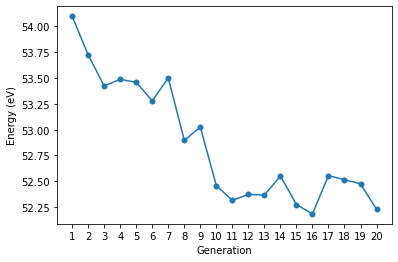

Creating and evaluating generation 21
Relaxing candidate 1050

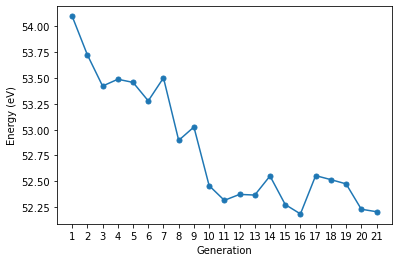

Creating and evaluating generation 22
Relaxing candidate 1100

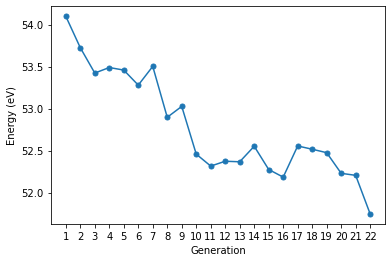

Creating and evaluating generation 23
Relaxing candidate 1150

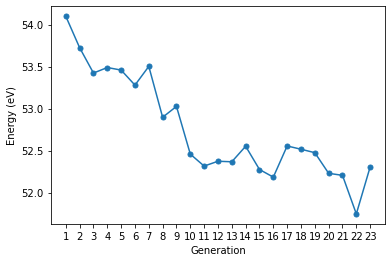

Creating and evaluating generation 24
Relaxing candidate 1200

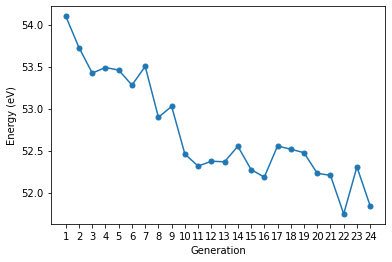

Creating and evaluating generation 25
Relaxing candidate 1250

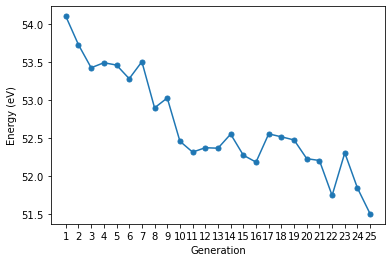

Creating and evaluating generation 26
Relaxing candidate 1300

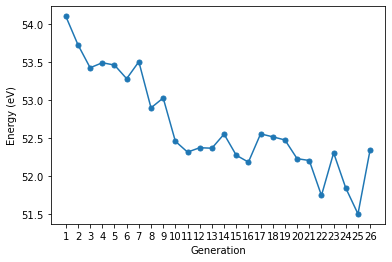

Creating and evaluating generation 27
Relaxing candidate 1350

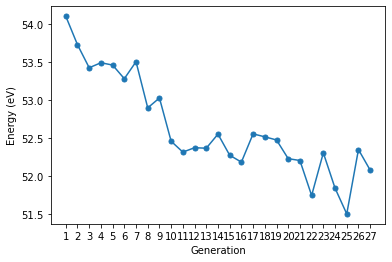

Creating and evaluating generation 28
Relaxing candidate 1400

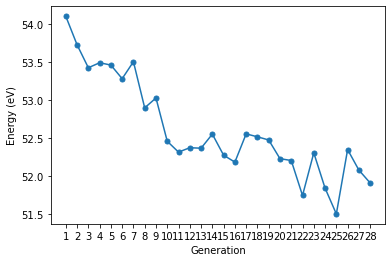

Creating and evaluating generation 29
Relaxing candidate 1450

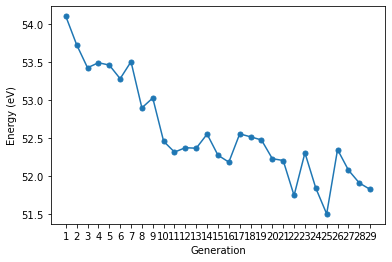

Creating and evaluating generation 30
Relaxing candidate 1500

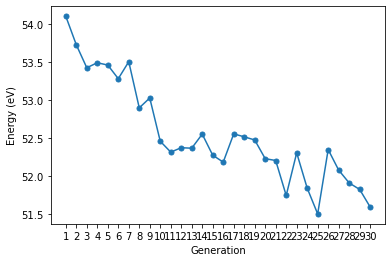

Creating and evaluating generation 31
Relaxing candidate 1550

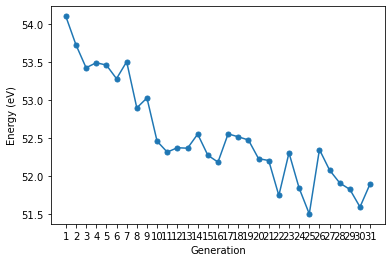

Creating and evaluating generation 32
Relaxing candidate 1600

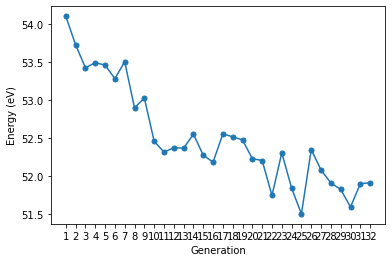

Creating and evaluating generation 33
Relaxing candidate 1650

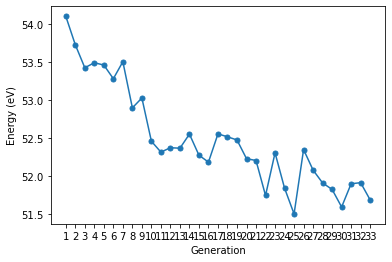

Creating and evaluating generation 34
Relaxing candidate 1700

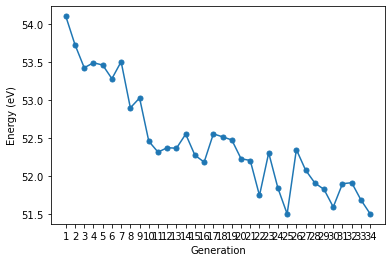

Creating and evaluating generation 35
Relaxing candidate 1750

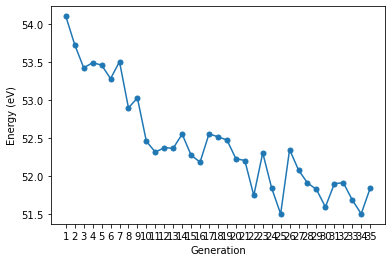

Creating and evaluating generation 36
Relaxing candidate 1800

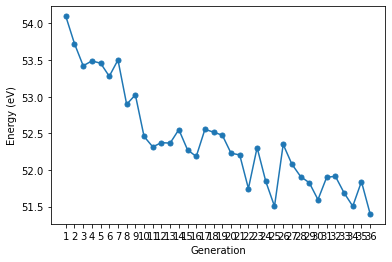

Creating and evaluating generation 37
Relaxing candidate 1850

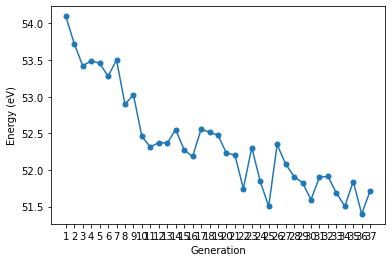

Creating and evaluating generation 38
Relaxing candidate 1900

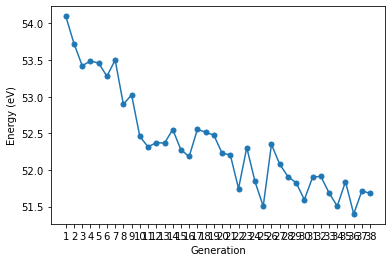

Creating and evaluating generation 39
Relaxing candidate 1950

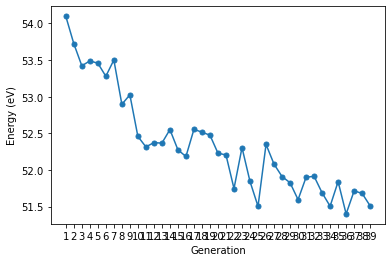

Creating and evaluating generation 40
Relaxing candidate 2000

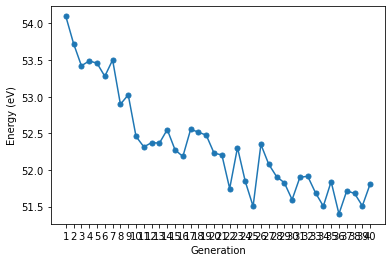

Creating and evaluating generation 41
Relaxing candidate 2050

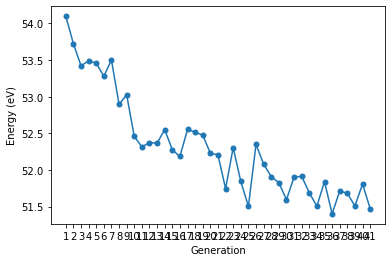

Creating and evaluating generation 42
Relaxing candidate 2100

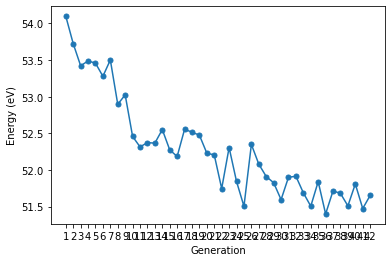

Creating and evaluating generation 43
Relaxing candidate 2150

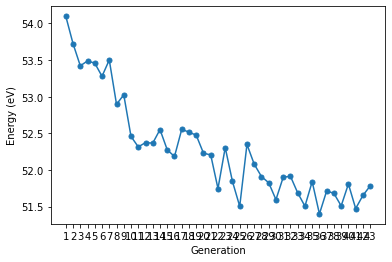

Creating and evaluating generation 44
Relaxing candidate 2200

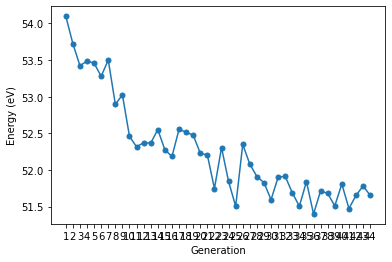

Creating and evaluating generation 45
Relaxing candidate 2250

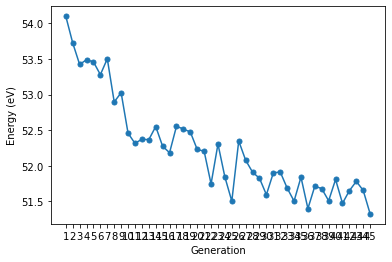

Creating and evaluating generation 46
Relaxing candidate 2300

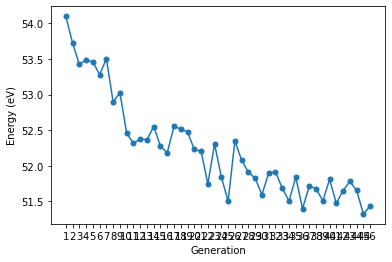

Creating and evaluating generation 47
Relaxing candidate 2350

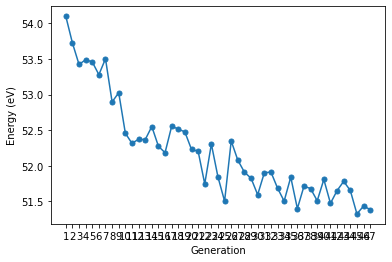

Creating and evaluating generation 48
Relaxing candidate 2400

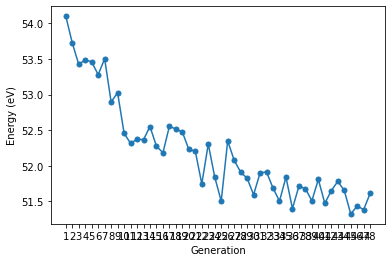

Creating and evaluating generation 49
Relaxing candidate 2450

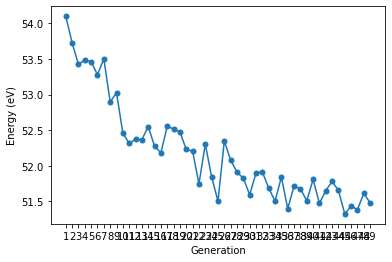

Creating and evaluating generation 50
Relaxing candidate 2500

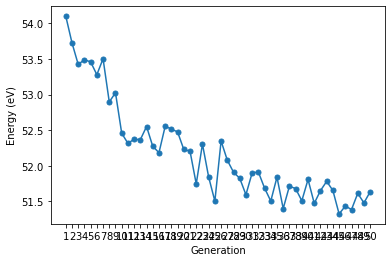

Creating and evaluating generation 51
Relaxing candidate 2550

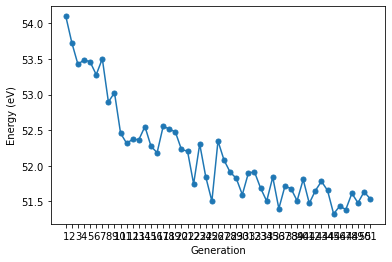

Creating and evaluating generation 52
Relaxing candidate 2600

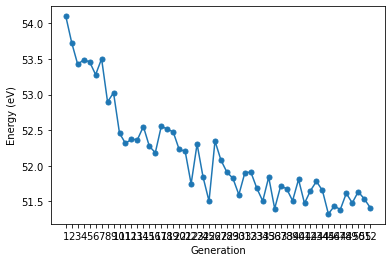

Creating and evaluating generation 53
Relaxing candidate 2650

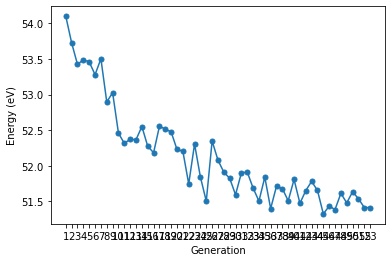

Creating and evaluating generation 54
Relaxing candidate 2700

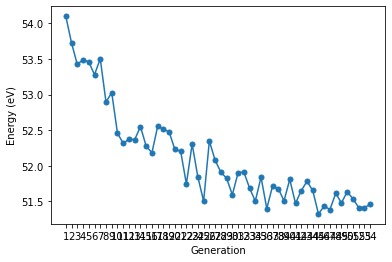

Creating and evaluating generation 55
Relaxing candidate 2750

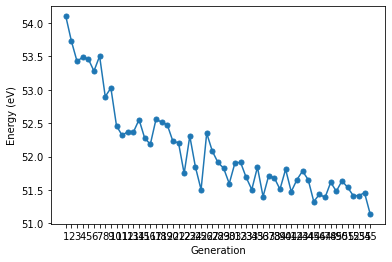

Creating and evaluating generation 56
Relaxing candidate 2800

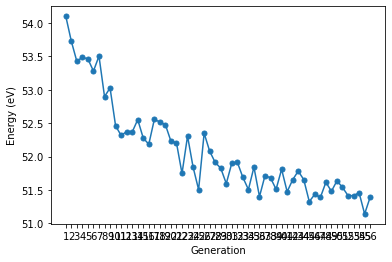

Creating and evaluating generation 57
Relaxing candidate 2850

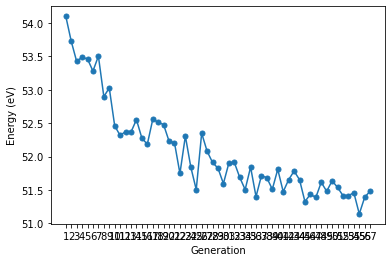

Creating and evaluating generation 58
Relaxing candidate 2900

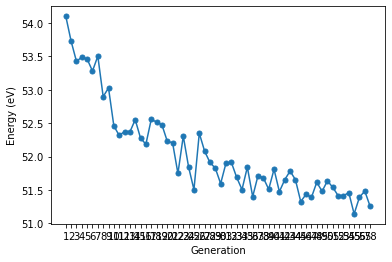

Creating and evaluating generation 59
Relaxing candidate 2946

In [ ]:
# Below is the iterative part of the algorithm
gen_num = db.get_generation_number()
ncand = gen_num * pop_size + 1
for i in range(num_gens):
    # Check if converged
    if cc.converged():
        print('Converged')
        break

    print('Creating and evaluating generation {0}'.format(gen_num + i + 1))
    new_generation = []
    e_gen = 1e5
    atoms_gen = None
    for _ in range(pop_size):
        # Select an operator and use it
        op = op_selector.get_operator()
        # Select parents for a new candidate
        p1, p2 = pop.get_two_candidates()
        parents = [p1, p2]
        offspring, desc = op.get_new_individual(parents)
        # An operator could return None if an offspring cannot be formed
        # by the chosen parents
        if offspring is None:
            continue
            
        print('\rRelaxing candidate {0}'.format(ncand), end='')
        relax(offspring)
        e = offspring.info['key_value_pairs']['EMT_energy']
        # Update the global minimum of the current generation
        if e < e_gen:
            e_gen = e
            atoms_gen = offspring
        new_generation.append(offspring)
        ncand += 1

    # Append to the list of global minima
    e_gm.append(e_gen)
    atoms_gm.append(atoms_gen)
    # Plot the current minima
    x = list(range(gen_num + i + 2 - len(e_gm), gen_num + i + 2))
    y = e_gm
    plt.xticks(range(min(x), math.ceil(max(x)) + 1))
    plt.xlabel('Generation')
    plt.ylabel('Energy (eV)')
    plt.plot(x, y, marker='.', markersize=10)
    plt.show()

    # We add a full relaxed generation at once, this is faster than adding
    # one at a time
    db.add_more_relaxed_candidates(new_generation)

    # update the population to allow new candidates to enter
    pop.update(new_generation)
    
shutil.copyfile(db_name, 'Ni118Pt29_emt.db')

## Visualizing the Results

Visualize minima for each generation and find the global minimum structure

In [ ]:
view(atoms_gm)